# Welcome to the Star Jeans Data Analysis

## Market research to launch a new clothing line

# 1 - Importing Python Libraries

In [1]:
import sqlalchemy as sa
import re
import sqlite3
import requests
import numpy  as np
import pandas as pd
import io
import seaborn as sns
import math

from bs4        import BeautifulSoup
from datetime   import datetime
from sqlalchemy import create_engine

# 2 - Data Collection

## Beautiful soup is a Python library for Web Scraping. It creates a parse tree that can be used to extract data from HTML on a website. 

In [2]:
# Parameters
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}

# URL
url = 'https://www2.hm.com/en_us/men/products/jeans.html'

# Request to URL
page = requests.get( url, headers=headers )

# BeautifulSoup Object
soup = BeautifulSoup( page.text, 'html.parser' )

# Pagination
total_item = soup.find_all( 'h2', class_='load-more-heading' )[0].get( 'data-total' )
page_number = math.ceil( int( total_item ) / 36 )
url02 = url + '?page-size=' + str( int( page_number*36 ) )

# Request to URL02
page = requests.get( url02, headers=headers )

# BeautifulSoup Object
soup = BeautifulSoup( page.text, 'html.parser' )

# ===================================== Product Data =====================================
products = soup.find( 'ul', class_='products-listing small' )
product_list = products.find_all( 'article', class_='hm-product-item' )

# product id
product_id = [p.get('data-articlecode') for p in product_list]

# product category
product_category = [p.get('data-category') for p in product_list]

# product name
product_list = products.find_all( 'a', class_="link" )
product_name = [p.get_text() for p in product_list]

# product price
product_list = products.find_all( 'span', class_="price regular" )
product_price = [p.get_text() for p in product_list]

data = pd.DataFrame( [product_id, product_category, product_name, product_price] ).T
data.columns = ['product_id', 'product_category', 'product_name', 'product_price']

ConnectionError: HTTPSConnectionPool(host='www2.hm.com', port=443): Max retries exceeded with url: /en_us/men/products/jeans.html (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002348BC610D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [3]:
data.shape

NameError: name 'data' is not defined

## 2.1 - Data Collection by Product

In [10]:
# empty dataframe
df_compositions = pd.DataFrame()

# unique columns for all products
aux = []

df_pattern = pd.DataFrame( columns=['Art. No.', 'Composition', 'Fit'] )

for i in range(len(data)):
  
    # API requests
    url = 'https://www2.hm.com/en_us/productpage.' + data.loc[i, 'product_id'] + '.html'
    print( 'Product: {}'.format( url ) )

    page = requests.get( url, headers=headers )

    # Beautiful Soup Object
    soup = BeautifulSoup( page.text, 'html.parser' )

    # ================================= color name =========================================
    product_list = soup.find_all( 'a', class_='filter-option miniature active' ) + soup.find_all( 'a', class_='filter-option miniature ' )
    
    # color name
    color_name = [p.get( 'data-color' ) for p in product_list]

    # product id
    product_id = [p.get( 'data-articlecode' ) for p in product_list]

    df_color = pd.DataFrame( [product_id, color_name] ).T
    df_color.columns = ['product_id', 'color_name']

    for j in range( len( df_color ) ):

        # API requests
        url = 'https://www2.hm.com/en_us/productpage.' + df_color.loc[j, 'product_id'] + '.html'

        print( 'Color: {}'.format( url ) )

        page = requests.get( url, headers=headers )

        # Beautiful Soup Object
        soup = BeautifulSoup( page.text, 'html.parser' )

        # ============================== Product Name ==========================================
        product_name = soup.find_all( 'h1', class_='primary product-item-headline' )
        product_name = product_name[0].get_text()
      
        # ============================== Product Price ==========================================
        product_price = soup.find_all( 'div', class_='primary-row product-item-price' )
        product_price = re.findall( r'\d+\.?\d+', product_price[0].get_text() )[0]

        # =============================== composition ==========================================
        product_composition_list = soup.find_all( 'div', class_='details-attributes-list-item' )
        product_composition = [list( filter( None, p.get_text().split( '\n' ) ) ) for p in product_composition_list]

        # rename dataframe
        df_composition = pd.DataFrame( product_composition ).T
        df_composition.columns = df_composition.iloc[0]

        # delete first row & complete where none
        df_composition = df_composition.iloc[1:].fillna( method='ffill' )

        # remove pocket, pocket lining, shell and lining
        df_composition['Composition'] = df_composition['Composition'].replace( 'Pocket: ', '', regex=True )
        df_composition['Composition'] = df_composition['Composition'].replace( 'Pocket lining: ', '', regex=True )
        df_composition['Composition'] = df_composition['Composition'].replace( 'Shell: ', '', regex=True )
        df_composition['Composition'] = df_composition['Composition'].replace( 'Lining: ', '', regex=True )

        # guarantee the same number of columns
        df_composition = pd.concat( [df_pattern, df_composition], axis=0 )

        # deleting unnecessary columns
        df_composition = df_composition.drop(df_composition.iloc[:, 3:], axis=1)

        # rename columns
        df_composition.columns = ['product_id', 'composition', 'fit']
        df_composition['product_name'] = product_name
        df_composition['product_price'] = product_price
      
        # keep new columns if it shows up
        aux = aux + df_composition.columns.tolist()

        # merge df_composition + df_color
        df_composition = pd.merge( df_composition, df_color, how='left', on='product_id' )

        # all products
        df_compositions = pd.concat( [df_compositions , df_composition], axis=0 )

# Join Showroom data + Details
df_compositions['style_id'] = df_compositions['product_id'].apply( lambda x: x[:-3] )
df_compositions['color_id'] = df_compositions['product_id'].apply( lambda x: x[-3:] )

# scrapy datetime
df_compositions['scrapy_datetime'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

Product: https://www2.hm.com/en_us/productpage.0690449051.html
Color: https://www2.hm.com/en_us/productpage.0690449051.html
Product: https://www2.hm.com/en_us/productpage.1004199003.html
Color: https://www2.hm.com/en_us/productpage.1004199003.html
Product: https://www2.hm.com/en_us/productpage.0690449043.html
Color: https://www2.hm.com/en_us/productpage.0690449043.html
Product: https://www2.hm.com/en_us/productpage.0985159001.html
Color: https://www2.hm.com/en_us/productpage.0985159001.html
Product: https://www2.hm.com/en_us/productpage.0690449056.html
Color: https://www2.hm.com/en_us/productpage.0690449056.html
Product: https://www2.hm.com/en_us/productpage.1004199001.html
Color: https://www2.hm.com/en_us/productpage.1004199001.html
Product: https://www2.hm.com/en_us/productpage.0690449022.html
Color: https://www2.hm.com/en_us/productpage.0690449022.html
Product: https://www2.hm.com/en_us/productpage.1024256001.html
Color: https://www2.hm.com/en_us/productpage.1024256001.html
Product:

IndexError: single positional indexer is out-of-bounds

In [11]:
df_compositions.shape

(266, 6)

# 3 - Data Cleaning

In [12]:
# product_id
df_data = df_compositions.dropna(subset=['product_id'])

# product_name
df_data['product_name'] = df_data['product_name'].str.replace( '\n', '' )
df_data['product_name'] = df_data['product_name'].str.replace( '\t', '' )
df_data['product_name'] = df_data['product_name'].str.replace( '  ', '' )
df_data['product_name'] = df_data['product_name'].str.replace( ' ', '_' ).str.lower()

# product_price
df_data['product_price'] = df_data['product_price'].astype(float)

# color_name
df_data['color_name'] = df_data['color_name'].str.replace( ' ','_' ).str.lower()

# fit
df_data['fit'] = df_data['fit'].str.replace( ' ','_' ).str.lower()

# size
#data['size_number'] = data['size'].apply( lambda x: re.search( '\d{3}cm', x ).group(0) if pd.notnull( x ) else x)
#data['size_number'] = data['size_number'].apply( lambda x: re.search( '\d+', x ).group(0) if pd.notnull( x ) else x)

# size model
#data['size_model'] = data['size'].str.extract( '(\d+/\\d+)' )

# drop duplicates
df_data = df_data.drop_duplicates( subset=['product_id', 'composition', 'fit', 'product_name', 'product_price', 'color_name', 'style_id', 'color_id', 'scrapy_datetime'], keep='last' )

# reset index
#data = data.reset_index( drop=True )

# break composition by comma
df1 = df_data['composition'].str.split( ',', expand=True ).reset_index(drop=True)

# cotton | polyester | spandex  | elastomultiester
df_ref = pd.DataFrame( index=np.arange( len(df_data) ), columns=['cotton', 'polyester', 'spandex', 'elastomultiester'] )

# =============================== composition ==========================================

# ---------- cotton ----------
df_cotton_0 = df1.loc[df1[0].str.contains( 'Cotton', na=True ), 0]
df_cotton_0.name = 'cotton'

df_cotton_1 = df1.loc[df1[1].str.contains( 'Cotton', na=True ), 1]
df_cotton_1.name = 'cotton'

# combine

df_cotton = df_cotton_0.combine_first( df_cotton_1 )

df_ref = pd.concat( [df_ref, df_cotton ], axis=1 )
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated( keep='last' )]

# ---------- polyester ----------
df_polyester_0 = df1.loc[df1[0].str.contains('Polyester', na=True), 0]
df_polyester_0.name = 'polyester'

df_polyester_1 = df1.loc[df1[1].str.contains('Polyester', na=True), 1]
df_polyester_1.name = 'polyester'

# combine

df_polyester = df_polyester_0.combine_first( df_polyester_1 )

df_ref = pd.concat( [df_ref, df_polyester], axis=1 )
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated( keep='last' )]

# ---------- spandex ----------
df_spandex_1 = df1.loc[df1[1].str.contains('Spandex', na=True), 1]
df_spandex_1.name = 'spandex'

df_spandex_2 = df1.loc[df1[2].str.contains('Spandex', na=True), 2]
df_spandex_2.name = 'spandex'

# combine

df_spandex = df_spandex_1.combine_first( df_spandex_2 )

df_ref = pd.concat( [df_ref, df_spandex], axis=1 )
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated( keep='last' )]

# ---------- elastomultiester ----------
df_elastomultiester = df1.loc[df1[1].str.contains('Elastomultiester', na=True), 1]
df_elastomultiester.name = 'elastomultiester'

df_ref = pd.concat( [df_ref, df_elastomultiester], axis=1 )
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated( keep='last' )]

# join of combine with product_id
df_aux = pd.concat( [df_data['product_id'].reset_index(drop=True), df_ref], axis=1 )

# format composition data
df_aux['cotton']     = df_aux['cotton'].apply( lambda x: int( re.search( '\d+', x ).group(0)) / 100 if pd.notnull( x ) else x)
df_aux['polyester']  = df_aux['polyester'].apply( lambda x: int( re.search( '\d+', x ).group(0)) / 100 if pd.notnull( x ) else x)
df_aux['spandex']   = df_aux['spandex'].apply( lambda x: int( re.search( '\d+', x ).group(0)) / 100 if pd.notnull( x ) else x)
df_aux['elastomultiester'] = df_aux['elastomultiester'].apply( lambda x: int( re.search( '\d+', x ).group(0)) / 100 if pd.notnull( x ) else x)

# final join
df_aux = df_aux.groupby( 'product_id' ).max().reset_index().fillna(0)
df_data = pd.merge( df_data, df_aux, on='product_id', how='left' )

# Drop columns
df_data = df_data.drop( columns=['composition'], axis=1 )

# drop duplicates
df_data = df_data.drop_duplicates()
df_data.shape

KeyError: Index(['color_id', 'scrapy_datetime', 'style_id'], dtype='object')

# 4 - Database Creation

In [ ]:
data_insert = df_data[[
    'product_id',
    'style_id',
    'color_id',
    'product_name',
    'color_name',
    'fit',
    'product_price',
    'cotton',
    'polyester',
    'spandex',
    'elastomultiester',
    'scrapy_datetime'
]]

In [ ]:
#query_showroom_schema = """
#    CREATE TABLE vitrine(
#        product_id        TEXT,
#        style_id          TEXT,
#        color_id          TEXT,
#        product_name      TEXT,
#        color_name        TEXT,
#        fit               TEXT,
#        product_price     REAL,
#        cotton            REAL,
#        polyester         REAL,
#        spandex           REAL,,
#        elastomultiester  TEXT,
#        scrapy_datetime   TEXT
#    )      
#"""

In [ ]:
# create table
conn = sqlite3.connect('database_hm.sqlite')
cursor = conn.execute( query_showroom_schema )
conn.commit()

In [ ]:
# create database connection
conn = create_engine( 'sqlite:///database_hm.sqlite', echo=False )

# data insert
data_insert.to_sql( 'vitrine', con=conn, if_exists='append', index=False )

# 5 - Data Loading

In [4]:
path = 'C:\\Users\\Leonardo de Freitas\\repos\\star_jeans'
database_name = 'database_hm.sqlite'
conn = create_engine('sqlite:///' + database_name, echo=False)

In [5]:
query = """
    SELECT * FROM vitrine
"""

In [6]:
df_raw = pd.read_sql_query( query, con=conn )

In [7]:
df_raw.head()

,product_id,style_id,color_id,product_name,color_name,fit,product_price,cotton,polyester,spandex,elastomultiester,scrapy_datetime
0,0985159001,0985159,001,skinny_jeans,black,skinny_fit,19.99,1.00,0.00,0.01,0.0,2022-03-24 06:58:48
1,1024256001,1024256,001,slim_jeans,black,slim_fit,19.99,0.99,0.65,0.01,0.0,2022-03-24 06:58:48
2,0690449043,0690449,043,skinny_jeans,light_denim_blue/trashed,skinny_fit,39.99,0.98,0.65,0.02,0.0,2022-03-24 06:58:48
3,0979945001,0979945,001,loose_jeans,light_denim_blue,loose_fit,39.99,1.00,0.65,0.00,0.0,2022-03-24 06:58:48
4,0690449022,0690449,022,skinny_jeans,black/trashed,skinny_fit,39.99,0.98,1.00,0.02,0.0,2022-03-24 06:58:48


# 6 - Data Overview

## 6.1 - Data description

In [20]:
df00 = df_raw.copy()

## Removing duplicates
df01 = df00.drop_duplicates()
df01.shape

(160, 12)

## 6.2 - Data dimension

In [21]:
print( 'Number of rows: {}'.format( df01.shape[0] ) )
print( 'Number of columns: {}'.format( df01.shape[1] ) )

Number of rows: 160
Number of columns: 12


## 6.3 - Data types

In [13]:
df01.dtypes

product_id           object
style_id             object
color_id             object
product_name         object
color_name           object
fit                  object
product_price       float64
cotton              float64
polyester           float64
spandex             float64
elastomultiester    float64
scrapy_datetime      object
dtype: object

## 6.4 - Identification of missing data

In [14]:
df01.isna().sum()

product_id          0
style_id            0
color_id            0
product_name        0
color_name          0
fit                 0
product_price       0
cotton              0
polyester           0
spandex             0
elastomultiester    0
scrapy_datetime     0
dtype: int64

In [15]:
df01.isna().sum() / df01.shape[0]

product_id          0.0
style_id            0.0
color_id            0.0
product_name        0.0
color_name          0.0
fit                 0.0
product_price       0.0
cotton              0.0
polyester           0.0
spandex             0.0
elastomultiester    0.0
scrapy_datetime     0.0
dtype: float64

# 7 - Descriptive Analysis

## Descriptive Analysis gives you a conclusion of the distribution of your data, helps you detect typos and outliers, and enables you to identify similarities among variables. 

In [16]:
num_attibutes = df01.select_dtypes( include=['int', 'float64'] )
cat_attibutes = df01.select_dtypes( exclude=['int', 'float64', 'datetime64[ns]'] )

In [17]:
# tendência central tendency - média, mediana

t1 = pd.DataFrame( num_attibutes.apply( np.mean ) ).T
t2 = pd.DataFrame( num_attibutes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, 
d1 = pd.DataFrame( num_attibutes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attibutes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attibutes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attibutes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attibutes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attibutes.apply( lambda x: x.kurtosis() ) ).T

# concat
m1 = pd.concat( [d2, d3, d4, t1, t2, d1, d5, d6] ).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,product_price,19.99,49.99,30.00,29.802500,29.99,9.761011,0.368557,-1.267842
1,cotton,0.77,1.00,0.23,0.976125,0.99,0.055543,-3.005839,7.711975
2,polyester,0.00,1.00,1.00,0.370500,0.65,0.327383,-0.085157,-1.759525
3,spandex,0.00,0.02,0.02,0.010000,0.01,0.006423,0.000000,-0.555705
4,elastomultiester,0.00,0.09,0.09,0.003687,0.00,0.017271,4.530421,18.849422


# 8 - Data Visualization

## 8.1 - Models x Prices 

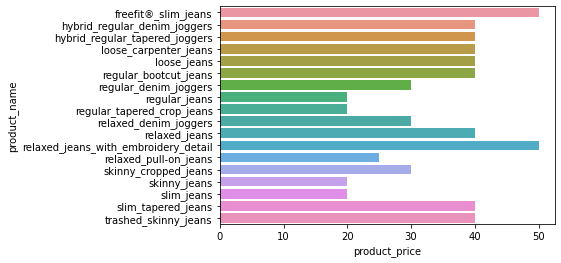

In [24]:
df1 = df_raw.groupby(['product_name'])['product_price'].median().reset_index()
sns.barplot( x='product_price', y='product_name', data=df1 );

## 8.2 - Models x No of Products

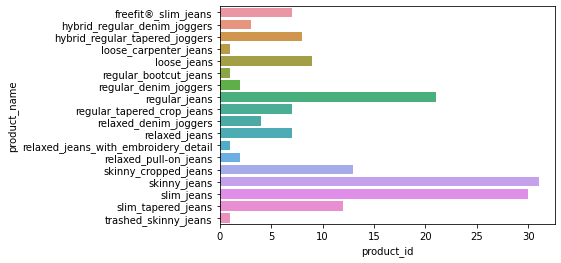

In [25]:
df2 = df01.groupby(['product_name'])['product_id'].count().reset_index()
sns.barplot( x='product_id', y='product_name', data=df2 );

## 8.3 - Colors x No of Products 

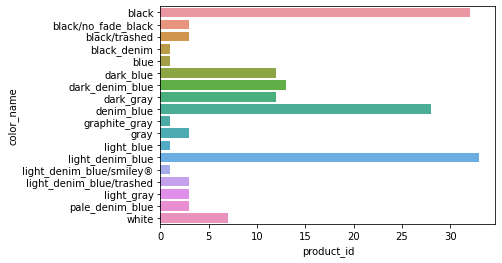

In [26]:
df3 = df01.groupby(['color_name'])['product_id'].count().reset_index()
sns.barplot( x='product_id', y='color_name', data=df3 );

# 9 - Business Results

## 9.1 - Media price for each model

In [31]:
df1.sort_values('product_price', axis=0, ascending=True).reset_index( drop=True )

,product_name,product_price
0,regular_tapered_crop_jeans,19.99
1,slim_jeans,19.99
2,skinny_jeans,19.99
3,regular_jeans,19.99
4,relaxed_pull-on_jeans,24.99
5,skinny_cropped_jeans,29.99
6,regular_denim_joggers,29.99
7,relaxed_denim_joggers,29.99
8,relaxed_jeans,39.99
9,trashed_skinny_jeans,39.99


In [42]:
# create csv file
df1.to_csv('price_report.csv', index=False)

## 9.2 - The most frequent models

In [38]:
df2.sort_values('product_id', axis=0, ascending=False).reset_index( drop=True )

,product_name,product_id
0,skinny_jeans,31
1,slim_jeans,30
2,regular_jeans,21
3,skinny_cropped_jeans,13
4,slim_tapered_jeans,12
5,loose_jeans,9
6,hybrid_regular_tapered_joggers,8
7,freefit®_slim_jeans,7
8,relaxed_jeans,7
9,regular_tapered_crop_jeans,7


## 9.3 - The most frequent colors

In [41]:
df3.sort_values('product_id', axis=0, ascending=False).reset_index( drop=True )

,color_name,product_id
0,light_denim_blue,33
1,black,32
2,denim_blue,28
3,dark_denim_blue,13
4,dark_gray,12
5,dark_blue,12
6,white,7
7,black/no_fade_black,3
8,gray,3
9,black/trashed,3
